# SMEs Participation in EU innovation Public Procurement: Analysis by Procedure Type and Contract-Value Clusters


The purpose of this notebook is to provide a coding sample aimed at carrying out a brief statistical analysis to investigate SME participation in EU innovation procurements, in order to assess their involvement in these tenders compared to traditional procurements and by contract value. The notebook is divided into three sections:

- Data Loading, Cleaning & Preprocessing

- Descriptive Analysis

- Considerations & Insights

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from itertools import combinations

# 1. Data loading, cleaning and preprocessing

**Objective:**
- 1.1. Data loading
- 1.2 Data cleaning
- 1.3 data segmentation

**Tasks**:
- 1.1. Data loading: read the TED DATASET into a Pandas DataFrame.

- 1.2.a) normalize the data in column `'B_CONTRACTOR_SME'` in order to identify tenders where the contractor is an SME; 
- 1.2.b) data parsing

- 1.3.a) Segment procurement of innovation tenders vs traditional tenders.  `isInnovation` identifies innovative tenders based on Competitive Dialogue (`'COD'`) or Innovation Partnership (`'INP'`); 
- 1.3.b) Segment awards into three value-based bins (Low, Medium, High) using quantile-based bins, ensure each cluster contains roughly equal numbers of observations. Bins correspond to the 0–33rd, 33–66th, and 66–100th percentiles of award value.


In [2]:
# 1.1 Data loading: read the TED DATASET into a Pandas DataFrame.

df = pd.read_csv('/Users/federicolubner/Desktop/analisi/DB/TED/Export_OpenDataCAN_from2018to2022.csv',low_memory=False)


In [3]:
# Visualization of TED DATASET

pd.set_option("display.max_columns", None)

df 

,ID_NOTICE_CAN,TED_NOTICE_URL,YEAR,ID_TYPE,DT_DISPATCH,XSD_VERSION,CANCELLED,CORRECTIONS,B_MULTIPLE_CAE,CAE_NAME,CAE_NATIONALID,CAE_ADDRESS,CAE_TOWN,CAE_POSTAL_CODE,CAE_GPA_ANNEX,ISO_COUNTRY_CODE,ISO_COUNTRY_CODE_GPA,B_MULTIPLE_COUNTRY,ISO_COUNTRY_CODE_ALL,CAE_TYPE,EU_INST_CODE,MAIN_ACTIVITY,B_ON_BEHALF,B_INVOLVES_JOINT_PROCUREMENT,B_AWARDED_BY_CENTRAL_BODY,TYPE_OF_CONTRACT,TAL_LOCATION_NUTS,B_FRA_AGREEMENT,FRA_ESTIMATED,B_FRA_CONTRACT,B_DYN_PURCH_SYST,CPV,MAIN_CPV_CODE_GPA,ID_LOT,ADDITIONAL_CPVS,B_GPA,GPA_COVERAGE,LOTS_NUMBER,VALUE_EURO,VALUE_EURO_FIN_1,VALUE_EURO_FIN_2,B_EU_FUNDS,TOP_TYPE,B_ACCELERATED,OUT_OF_DIRECTIVES,CRIT_CODE,CRIT_PRICE_WEIGHT,CRIT_CRITERIA,CRIT_WEIGHTS,B_ELECTRONIC_AUCTION,NUMBER_AWARDS,ID_AWARD,ID_LOT_AWARDED,INFO_ON_NON_AWARD,INFO_UNPUBLISHED,B_AWARDED_TO_A_GROUP,WIN_NAME,WIN_NATIONALID,WIN_ADDRESS,WIN_TOWN,WIN_POSTAL_CODE,WIN_COUNTRY_CODE,B_CONTRACTOR_SME,CONTRACT_NUMBER,TITLE,NUMBER_OFFERS,NUMBER_TENDERS_SME,NUMBER_TENDERS_OTHER_EU,NUMBER_TENDERS_NON_EU,NUMBER_OFFERS_ELECTR,AWARD_EST_VALUE_EURO,AWARD_VALUE_EURO,AWARD_VALUE_EURO_FIN_1,B_SUBCONTRACTED,DT_AWARD
0,20184,ted.europa.eu/udl?uri=TED:NOTICE:4-2018:TEXT:E...,2018,3,22-DEC-17,R209.S2,0,0,N,European Insurance and Occupational Pensions A...,NaN,WesthafenTower; Westhafenplatz 1,Frankfurt am Main,60327,A1,DE,EU,N,NaN,5,AG,General public\services,N,N,N,S,DE712,Y,NaN,Y,N,72300000,72.0,2,72319000,Y,2.0,1.0,NaN,NaN,NaN,Y,OPE,NaN,0,M,30,Technical quality,70,N,1,8447164.0,2,PROCUREMENT_UNSUCCESSFUL,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EIOPA/OP/009/2017; Lot 2,Financial Market Input Data for Validation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN
1,20185,ted.europa.eu/udl?uri=TED:NOTICE:5-2018:TEXT:E...,2018,3,22-DEC-17,R209.S2,0,0,N,European Food Safety Authority (EFSA),NaN,Via Carlo Magno 1A,Parma,43126,A1,IT,EU,N,NaN,5,AG,General public\services,N,N,N,S,ITH52,Y,NaN,Y,N,79411000,794.0,NaN,NaN,N,2.0,1.0,1500000.00,1500000.00,1500000.00,N,OPE,NaN,0,M,NaN,Cheapest price offer/price of tender X---Measu...,40---60,N,2,8447165.0,NaN,NaN,N,Y,ELT associati di Guaglio Davide e Molinari Pao...,NaN,Via Mantovanella 4---Galleria Crocetta 10/a---...,Mantova---Parma---Parma---Parma---Parma,46100---43126---43126---43123---43122,IT---IT---IT---IT---IT,Y---Y---Y---Y---Y,OC/EFSA/CORSER/2017/03 - FWC 01,Consultancy services to improve efficiency and...,2.0,2.0,0.0,0.0,NaN,1500000.00,1500000.00,1500000.00,N,18-DEC-17
2,20185,ted.europa.eu/udl?uri=TED:NOTICE:5-2018:TEXT:E...,2018,3,22-DEC-17,R209.S2,0,0,N,European Food Safety Authority (EFSA),NaN,Via Carlo Magno 1A,Parma,43126,A1,IT,EU,N,NaN,5,AG,General public\services,N,N,N,S,ITH52,Y,NaN,Y,N,79411000,794.0,NaN,NaN,N,2.0,1.0,1500000.00,1500000.00,1500000.00,N,OPE,NaN,0,M,NaN,Cheapest price offer/price of tender X---Measu...,40---60,N,2,8447166.0,NaN,NaN,N,N,A.I.Erre engineering,NaN,Strada Cavagnari 10,Parma,43126,IT,Y,OC/EFSA/CORSER/2017/03 - FWC02,Consultancy service to improve efficiency and ...,2.0,2.0,0.0,0.0,NaN,1500000.00,1500000.00,1500000.00,N,18-DEC-17
3,201858,ted.europa.eu/udl?uri=TED:NOTICE:58-2018:TEXT:...,2018,3,22-DEC-17,R209.S2,0,0,N,European Commission-Directorate General for En...,NaN,European Commission Directorate General Energy...,Luxembourg,2530,A1,LU,EU,N,NaN,5,EC,General public\services,N,N,N,S,00,Y,NaN,Y,N,48000000,48.0,NaN,NaN,Y,1.0,1.0,1464400.00,1464400.00,1464400.00,N,OPE,NaN,0,M,40,Organisation of the work---Quality control mea...,20---20---60,N,1,8447168.0,NaN,NaN,N,Y,Dialogika GmbH---Dokumenta S.A.,NaN,Pascalschacht 1---Rue d'Epernay 16,Saarbrûcken---Luxembourg,66125---1490,DE---LU,Y---Y,NaN,Framework Service Contract covering the mainte...,1.0,NaN,NaN,NaN,NaN,2000000.00,1464400.00,1464400.00,N,13-NOV-17
4,201859,ted.europa.eu/udl?uri=TED:NOTICE:59-2018:TEXT:...,2018,3,22-DEC-17,R209.S2,0,0,N,European Commission; Directorate-General for R...,NaN,TA Cell - BU-1,Bruxelles,1049,A1,BE,EU,N,NaN,5,EC,General public\services,N,N,N,S,PT,N,NaN,N,N,79000000,790.0,NaN,72700000,Y,1.0,1.0,270750.00,270750.00,2

In [4]:
# 1.2 Data cleaning: 


# 1.2.a normalize the data in column`'B_CONTRACTOR_SME'` in order to identify tenders where the contractor is an SME;

df['B_CONTRACTOR_SME_clean'] = (
    df['B_CONTRACTOR_SME']      
      .fillna('')                
      .str.contains('y', case=False, na=False)  
      .map({True: 'Y', False: 'N'})) 

df['B_CONTRACTOR_SME_flag'] = df['B_CONTRACTOR_SME_clean'].map({'Y': 1, 'N': 0})



# 1.2.b parsing award date to datetime
df['DT_AWARD'] = pd.to_datetime(df['DT_AWARD'], errors='coerce')


# 1.3 data segmentation:

# 1.3.a) Segment procurement of innovation tenders vs traditional tenders

df['isInnovation'] = df['TOP_TYPE'].isin(['COD', 'INP'])

In [5]:
# 1.3 b) Segment awards into three value-based bins (Low, Medium, High)

df['value_cluster'] = pd.qcut(
    df['AWARD_VALUE_EURO_FIN_1'],
    q=3,
    labels=['Low', 'Medium', 'High']
)
print(df['value_cluster'].value_counts())

Medium    1417647
Low       1417646
High      1417645
Name: value_cluster, dtype: int64


# 2. Descriptive Analysis

**Objectives:**
- 2.1: Analysis on SMEs partecipation per type of procurement (traditional procurement vs innovation procurement)
- 2.2: Analysis on SMEs partecipation per type of procurement (traditional procurement vs innovation procurement) and value of contract

**Tasks**:
- 2.1.a: Calculate SMEs partecipation percentage per award: compute the share of bids submitted by SMEs for each award (SME participation rate). `pct_SME` column quantifies SMEs engagement per award
- 2.1.b: Summarize average SMEs participation and count awards by procedure type, highlighting differences in SMEs engagement between innovative and traditional tenders.
- 2.1.c: Visualization: SMEs Participation Comparison through bar chart comparing SMEs participation rates for traditional vs. innovative tenders.
- 2.1.d: Proportion Test (Z-test): test whether the difference in SMEs participation rates between innovative and traditional tenders is statistically significant.
- 2.1.e: Odds Ratio Calculation: estimate the odds ratio comparing the likelihood of SMEs bids in innovative vs. traditional tenders.

- 2.2.a: Summarize average SMEs participation and count awards by procedure type and by cluster of tender value.
- 2.2.b Visualization SMEs Participation Comparison (by tender type and by clusters of tender value).
- 2.2.c Proportion Test (Z-test): Sum total SMEs bids for each combination of value cluster (Low vs Medium;Low vs High;Medium vs High) within innovation tenders.


**2.1: Analysis on SMEs partecipation per type of procurement (traditional procurement vs innovation procurement)**

In [6]:
# 2.1.a Calculate SMEs partecipation percentage per award

df['pct_SME'] = df['NUMBER_TENDERS_SME'] / df['NUMBER_OFFERS']

# Removing records without info
df = df.dropna(subset=['pct_SME'])
print(df['pct_SME'].describe())

count    1.885729e+06
mean     6.917516e-01
std      6.531702e-01
min      0.000000e+00
25%      2.500000e-01
50%      1.000000e+00
75%      1.000000e+00
max      1.330000e+02
Name: pct_SME, dtype: float64


In [7]:
# 2.1.b Summarize average SMEs participation and count awards by procedure type

summary = (
    df
    .groupby('isInnovation')
    .agg(
        mean_pct_SME=('pct_SME', 'mean'),
        count_awards=('ID_AWARD', 'nunique')
    )
    .reset_index()
)
print(summary)


   isInnovation  mean_pct_SME  count_awards
0         False      0.691977       1853112
1          True      0.498568          2186


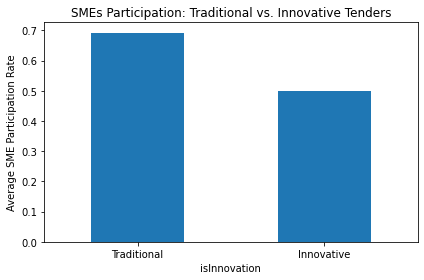

In [8]:
#2.1.c Visualization SMEs Participation Comparison (by tender type)

fig, ax = plt.subplots()
summary.plot.bar(
    x='isInnovation',
    y='mean_pct_SME',
    legend=False,
    ax=ax
)
ax.set_xticklabels(['Traditional', 'Innovative'], rotation=0)
ax.set_ylabel('Average SME Participation Rate')
ax.set_title('SMEs Participation: Traditional vs. Innovative Tenders')
plt.tight_layout()
plt.show()


In [9]:
# 2.1.d Proportion Test (Z-test)
# Sum total bids and SMEs bids for each group

mask_innov = df['isInnovation']
tot_SME_innov = df.loc[mask_innov, 'NUMBER_TENDERS_SME'].sum()
tot_offers_innov = df.loc[mask_innov, 'NUMBER_OFFERS'].sum()
tot_SME_trad = df.loc[~mask_innov, 'NUMBER_TENDERS_SME'].sum()
tot_offers_trad = df.loc[~mask_innov, 'NUMBER_OFFERS'].sum()

count = [tot_SME_innov, tot_SME_trad]
nobs = [tot_offers_innov, tot_offers_trad]
stat, pval = proportions_ztest(count, nobs)
print(f"Z-test statistic: {stat:.3f}, p-value: {pval:.3f}")


Z-test statistic: -31.181, p-value: 0.000


**2.2: Analysis on SMEs partecipation per type of procurement (traditional procurement vs innovation procurement) and value of contract**

In [10]:
# 2.2.a: Summarize average SMEs participation and count awards by procedure type and by cluster of tender value


cluster_summary = (
    df
    .groupby('value_cluster')
    .agg(
        mean_pct_SME=('pct_SME', 'mean'),
        count_awards=('ID_AWARD', 'nunique')
    )
    .reset_index()
)
print(cluster_summary)


  value_cluster  mean_pct_SME  count_awards
0           Low      0.656392        379738
1        Medium      0.715870        863541
2          High      0.680212        604549


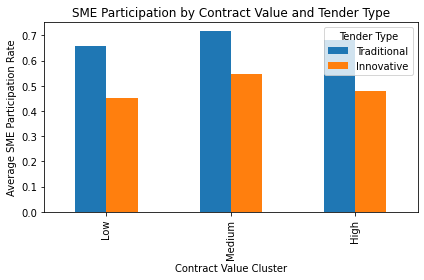

In [11]:
# 2.2.b Visualization SMEs Participation Comparison (by tender type and by clusters of tender value)


df_plot = (
    df
    .groupby(['value_cluster', 'isInnovation'])
    .agg(mean_pct_SME=('pct_SME', 'mean'))
    .reset_index()
)

# Pivot so that columns are tender types
pivot = df_plot.pivot(index='value_cluster', columns='isInnovation', values='mean_pct_SME')

# Rename columns for readability
pivot.columns = ['Traditional', 'Innovative']

# Plot grouped bar chart
fig, ax = plt.subplots()
pivot.plot.bar(ax=ax)
ax.set_xlabel('Contract Value Cluster')
ax.set_ylabel('Average SME Participation Rate')
ax.set_title('SME Participation by Contract Value and Tender Type')
ax.legend(title='Tender Type')
plt.tight_layout()
plt.show()


In [12]:
# 2.2.c Proportion Test (Z-test)
# Sum total SMEs bids for each combination of value cluster (Low vs Medium;Low vs High;Medium vs High) within innovation tenders


df_innov = df[df['isInnovation']]

cluster_counts = (
    df_innov
    .groupby('value_cluster')
    .agg(
        tot_SME=('NUMBER_TENDERS_SME', 'sum'),
        tot_offers=('NUMBER_OFFERS', 'sum')
    )
    .reset_index()
)
print("Count summary per cluster (Innovation tenders):")
print(cluster_counts, "\n")


for c1, c2 in combinations(cluster_counts['value_cluster'], 2):
    n_sme_1 = int(cluster_counts.loc[cluster_counts['value_cluster']==c1, 'tot_SME'])
    n_tot_1 = int(cluster_counts.loc[cluster_counts['value_cluster']==c1, 'tot_offers'])
    n_sme_2 = int(cluster_counts.loc[cluster_counts['value_cluster']==c2, 'tot_SME'])
    n_tot_2 = int(cluster_counts.loc[cluster_counts['value_cluster']==c2, 'tot_offers'])
    
    stat, pval = proportions_ztest(
        count=[n_sme_1, n_sme_2],
        nobs=[n_tot_1, n_tot_2]
    )
    print(f"Z-test {c1} vs {c2}: Z = {stat:.3f}, p-value = {pval:.4f}")

Count summary per cluster (Innovation tenders):
  value_cluster  tot_SME  tot_offers
0           Low    337.0       870.0
1        Medium    831.0      1827.0
2          High   1902.0      3912.0 

Z-test Low vs Medium: Z = -3.307, p-value = 0.0009
Z-test Low vs High: Z = -5.284, p-value = 0.0000
Z-test Medium vs High: Z = -2.215, p-value = 0.0267


# 3. Considerations and insights


**A) Absolute difference in SME share**

Traditional tenders see on average 69.2% of bids coming from SMEs, whereas innovative tenders only see 49.9%.

That’s a raw drop of about 19.3 percentage points—a substantial gap.

**B) Relative comparison**

RR= 0.4986/0.69198 ≈ 0.72

SMEs are bidding to innovative tenders at only about 72% of the rate they bid to traditional ones (i.e. a 28% relative reduction).

**C) Odds Ratio**

If we convert each proportion into odds:

**ODDSinnov** = 0.4986/(1 − 0.4986)≈ **0.994**

**ODDStrad** = 0.69198/(1 − 0.69198) ≈ **2.246**

Then:

**OR= 0.994/2.246 ≈ 0.44**

So the odds that a given bid is from an SME are roughly 56 % lower in innovative tenders than in traditional ones.

**Sample sizes and statistical power**

We can notice that in the datasets there are ~1.85 million traditional awards vs. just ~2 200 innovative awards.

The sheer imbalance means that the Z-test was overwhelmingly powered (hence Z≈–31.2, p≪0.001), but the effect size (the ~0.20 difference in proportions) is what’s really interesting. Indeed, Effect Size (Absolute Difference in Proportions)
The SME‐participation rate in traditional tenders is 0.6919 (69.19 %), whereas in innovative tenders it is 0.4986 (49.86 %). The absolute difference of 19.33%, indicates that traditional procedures attract nearly one‐fifth more SME bids than innovation procurement call for tenders. Such a large gap justifies targeted measures (e.g., SME incubation schemes, simplified tender documents, dedicated innovation calls) to boost SME involvement in innovation‐focused contracts.

**Insights**

These findings suggest that current innovation‐procurement policies are not effectively encouraging SME participation. Possible discouraging factors include:

**Barrier to Entry**
Innovation procedures impose a series of hurdles that disproportionately impact SMEs, limiting their ability to compete on equal footing with larger organizations:

**Technical and Administrative Complexity**
Innovation partnerships and competitive dialogues typically require detailed proposals outlining novel technical solutions, project roadmaps, risk mitigation plans, and intellectual property management strategies. Preparing these documents demands specialized expertise—often requiring legal, financial, and technical advisors—that many SMEs lack in-house. The sheer volume and sophistication of paperwork can discourage smaller firms with lean project teams.

**Resource and Capacity Requirements**
These tenders often involve multi-phase procurement processes (e.g., preliminary concept validation, prototyping, final development) and may span several years. SMEs must allocate staff time, invest in R&D, and secure working capital up front, without guaranteed award. Larger companies, by contrast, can amortize these costs across broader portfolios or self-finance development phases, making high-resource calls less risky for them.

**Financial Guarantees and Bonding**
Many high-value innovation contracts demand performance guarantees, bid bonds, or parent-company guarantees that tie up SMEs’ limited capital or require external collateral. Smaller enterprises frequently struggle to meet bank guarantee thresholds or negotiate favorable bonding terms, especially when cash-flow is already committed to core operations.

**Consortium Expectations**
Innovation tenders often favor or even mandate consortium bids, bringing together multiple stakeholders (e.g., research institutes, large integrators, technology partners). While consortiums can distribute costs and risks, forming and managing a network of partners—defining roles, aligning objectives, negotiating IP sharing—requires significant legal and managerial bandwidth. SMEs may lack both the network connections and project management resources to lead or even join such consortia effectively.

**Risk Perception and Market Reputation**
Innovation contracts carry higher uncertainty around deliverables, timelines, and market outcomes. Public buyers may see large, established firms as safer bets for cutting-edge projects, reinforcing a cycle where SMEs are bypassed even if they possess specialized niche expertise. This perception gap can deter SMEs from bidding, fearing reputational damage from failed high-stakes procurements.